# 回帰型ニューラルネットワーク (RNN) と時系列データ




# 概要
第5回は，時系列データの予測と相性の良いRNNについて説明します．RNNを実装し，時系列データの予測問題を解けるようになることを目的とします．


# 復習：これまで扱ってきたNN

これまで扱ってきたNNはフィードフォワード型でした。

<img src='https://raw.githubusercontent.com/Toshiki-Keio/introduction-to-deep-learning/main/day5/fig/0.png' width="300" >

フィードフォワード型NNは入力から出力まで一方通行です。すなわち、ある時刻$t$における入力$\mathbf{x}_t$がNNを通過して出力$\mathbf{y}_t$となります。
この過程で過去の入力$\mathbf{x}_{t-1}, \mathbf{x}_{t-2}...$ は考慮されていません。

これまで、このモデルを用いて住宅価格の予測や手書き文字の識別を行ってきました。これらの問題はデータの順序を考慮する必要がなかったのでフィードフォワード型NNで十分でした。

しかし、データの順序を考慮したい場合もあります。例えば株価予測は過去の値の変動から傾向を見出して将来の値を推測することが行われます。
また、会話文を生成するタスクでは、言語は前後の単語間に関係性があることが多いため、順序を考慮したくなります。

これから紹介する**RNN (Reccurent Neural Network)**は、このようなデータの順番を考慮することが可能なNNです。イメージとしては、以下の図のように隠れ層$h$に一時刻前の情報$h_{t-1}$を現在$h_t$に伝達する経路を追加します。これにより、過去の情報を現在に反映し、かつ過去の情報の記憶も可能になります。

<img src='https://raw.githubusercontent.com/Toshiki-Keio/introduction-to-deep-learning/main/day5/fig/1.png' width="300" >


本講習会では順序を考慮するデータのうち、時間的に変化するデータである**時系列データ**に話を絞り、RNNの設計と学習を行っていきます。

# RNN


以下のセルを実行するとRNNの説明スライドがノートブック上に表示されます。

あるいは、[こちらのリンク](https://docs.google.com/presentation/d/e/2PACX-1vSbCOpBW69DJ86NjYuA_ZCuxEPdoZR29COhhEmhW9GLI0IO_6BEa3V1P0WbzudmOg/pub?start=false&loop=false&delayms=3000)を押していただくと説明スライドのページへ遷移します。

In [ ]:
import IPython
from IPython.display import display, HTML

htm = HTML('''\
<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vSbCOpBW69DJ86NjYuA_ZCuxEPdoZR29COhhEmhW9GLI0IO_6BEa3V1P0WbzudmOg/embed?start=false&loop=false&delayms=3000" frameborder="0" width="640" height="389" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>
''')
display(htm)

# 例題：ノイズの乗ったcos波の値予測

RNNを用いてノイズの乗ったcos波の値を予測する例題を通して，以下のことを学びます．
- データの前処理（スケーリング）
- 訓練データの作成方法
- RNNのモデル構築
- 学習方法
- 評価方法

## データの準備

### ノイズの乗ったcos波の生成

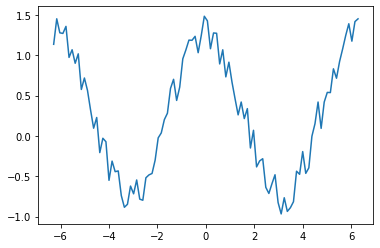

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-2*np.pi, 2*np.pi, 100)  # -2πから2πまで100ステップに分割
y = np.cos(x) + 0.5 * np.random.rand(len(x))  # cos関数に乱数でノイズを加える
plt.plot(x, y)

### データの前処理（スケーリング）

時系列データを学習させる前に，データの**スケーリング**を行います．

スケーリングとは，データをある一定の範囲に変換する処理のことで，以下のメリットがあります．

- データの値の範囲を揃えることで公平に比較
  - 例）身長と体温を入力するモデルの場合，身長のほうが値やその範囲が体温と比較して大きいため，身長の差が体温のそれよりも大きな影響を及ぼしてしまう．スケーリングをすることで身長，体温の差が公平に比較される．
  - 今回は単一のデータ系列の値予測のため，この点は問題ない
- 学習コストが低減する
  - 勾配降下法でパラメータを更新する際の更新幅がデータの値の大きさに依存する
  - データにスケーリングを施すと，各特徴量におけるパラメータの更新幅が揃い，最適解を見つけるまでのステップ数が少なくなる





スケーリングの手法として，**正規化**，**標準化**が挙げられます．

正規化とは
- データの値の範囲が0~1になるような変換

標準化とは
- データの値の平均が0，標準偏差が1になるような変換


正規化，標準化は一般に以下のように使い分けられます．
- 正規化
  - 最大値と最小値がおおむねわかっているとき
    - 最大（小）値がわかっていない場合，外れ値が発生してしまい，それを誤って最大（小）値とすることで誤ったスケーリングをする可能性があるため
  - 使用例）画像入力：各セルの値の範囲は0~255
- 標準化
  - 最大値と最小値がわかっていない場合

今回はcos波に若干のノイズを加えたデータで，値の範囲はおおむね-1~1であるといえるため，**正規化**を用います．

**実装**

正規化，標準化はscikit-learnを用いて以下のように実装できます．また，スケーリングのデータをもとのスケールに戻すことも可能です．

```python
from sklearn.preprocessing import MinMaxScaler # 正規化のモジュール
from sklearn.preprocessing import StandardScaler # 標準化のモジュール
 
ms = MinMaxScaler() # 正規化のクラスを準備
ss = StandardScaler() # 標準化のクラスを準備

# dataにデータが入っているとする

# スケーリング
data_ms_scaled = ms.fit_transform(data) # 正規化
data_ss_scaled = ss.fit_transform(data) # 標準化
 
# スケーリング済みのデータをもとに戻す
data_ms = ms.inverse_transform(data_ms_scaled) # 正規化の逆変換
data_ms = ms.inverse_transform(data_ms_scaled) # 標準化の逆変換
```

**時系列データの前処理**

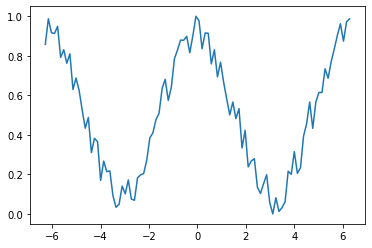

In [ ]:
from sklearn.preprocessing import MinMaxScaler # 正規化のモジュール
ms = MinMaxScaler() # 正規化のクラスを準備
# スケーリング
y = y.reshape(-1, 1) # fit_transformに入力できるようにreshape
y = ms.fit_transform(y) # 正規化
plt.plot(x, y)

## 訓練データの作成

時系列データからRNNを学習させるための訓練データを作成します．

今回は，全体のうちの前半70%を訓練用とします．


In [ ]:
train_size = int(len(y)*0.70)
test_size = len(y) - train_size

train = y[0:train_size, :]
test = y[train_size:len(y), :]

print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 70, test size: 30 


訓練データを作成します．今回は入力のステップ数を20とします．以下の図のように入力と正解を作っていきます．

<img src='https://raw.githubusercontent.com/Toshiki-Keio/introduction-to-deep-learning/main/day5/fig/2.png' width="500" >

In [ ]:
time_step = 20  # 時系列の数

n_sample = train_size-time_step-1  # サンプル数

input_data = np.zeros((n_sample, time_step, 1))  # 入力の空配列
correct_data = np.zeros((n_sample, 1))  # 正解の空配列

"""
イメージ
0,1,2,・・・19        +  正解データt=20
  1,2,・・・19,20     +  正解データt=21
    2,・・・19,20,21  +  正解データt=22
"""
for i in range(n_sample):
    input_data[i] = y[i:i+time_step]
    correct_data[i] = y[i+time_step]  # 正解は入力よりも一つ後

PyTorchのDataLoaderで読み込みます．今回はバッチサイズは8とします．



In [ ]:
import torch
from torch.utils.data import DataLoader

BATCH_SIZE = 8

input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)

dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)  # DataLoaderの設定

## モデルの構築

PyTorchを用いてRNNのモデルを構築します．

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.input_size = input_size # 入力データの次元
        self.hidden_dim = hidden_dim # 隠れ層の次元
        self.n_layers = n_layers # RNNを「上方向に」何層重ねるか？の設定 ※横方向ではない

        # RNNレイヤ．内部構造はすでに組まれている.
        # Dataloaderから取り出されるデータの仕様と合わせるためにbatch_first=True
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size) # 隠れ状態 ➡ 出力の全結合層

    def forward(self, x):
        x = x.to(device)
        y_rnn, h = self.rnn(x, None) # 隠れ層の初期値を0とする場合Noneでよい．
        y = self.fc(y_rnn[:, -1, :]) # 最後の時刻の出力だけを使用するので-1 (y_rnn[batch, time_step, hidden_size])
        return y


In [ ]:
#RNNの設定
n_inputs  = 1 # 入力は一次元
n_outputs = 1 # 出力も一次元
n_hidden  = 64 # 隠れ状態を64個に設定
n_layers  = 1 # 普通のRNN

model = RNN(n_inputs, n_outputs, n_hidden, n_layers).to(device) # RNNをインスタンス化
print(model) # 作成したRNNの層を簡易表示


RNN(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 学習

これまでの講習会と同様の書き方で学習をさせることができます．

今回は損失関数としてMSE，最適化アルゴリズムとしてAdamを用います．

また，学習率は0.001とし，200エポック学習させます．

In [ ]:
LEARNING_RATE = 0.001
EPOCHS = 200

学習中に20エポックごとに予測をさせ，学習の進行度合いを見ます．

<img src='https://raw.githubusercontent.com/Toshiki-Keio/introduction-to-deep-learning/main/day5/fig/3.png' width="300" >

Epoch: 20 Loss_Train: 0.005819374587320324


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


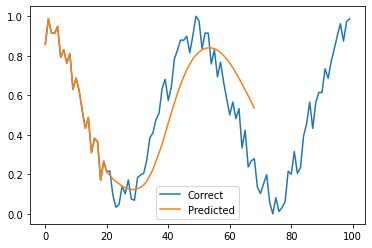

Epoch: 40 Loss_Train: 0.007010364139984761


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


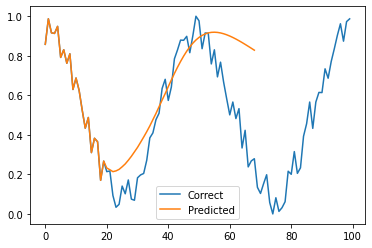

Epoch: 60 Loss_Train: 0.004529372356565935


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


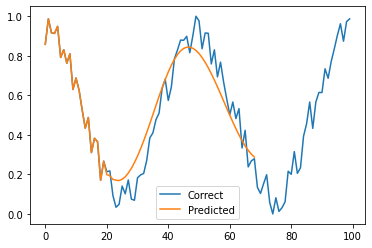

Epoch: 80 Loss_Train: 0.006689165120146104


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


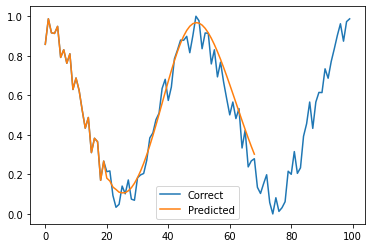

Epoch: 100 Loss_Train: 0.005042666669136712


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


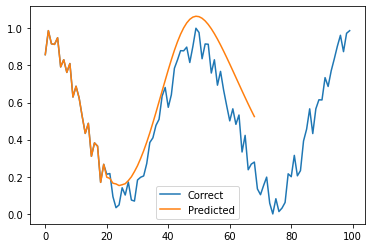

Epoch: 120 Loss_Train: 0.0038295451408235487


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


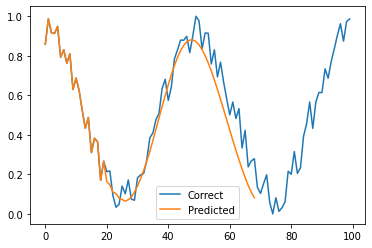

Epoch: 140 Loss_Train: 0.004868676520085761


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


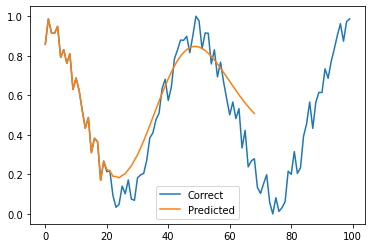

Epoch: 160 Loss_Train: 0.005172694268237267


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


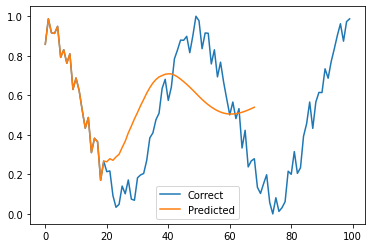

Epoch: 180 Loss_Train: 0.0032545591072578517


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


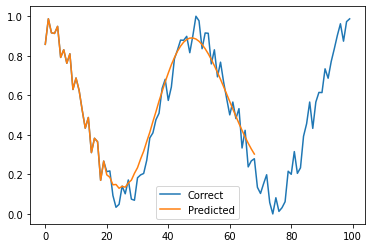

Epoch: 200 Loss_Train: 0.004780939264622118


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


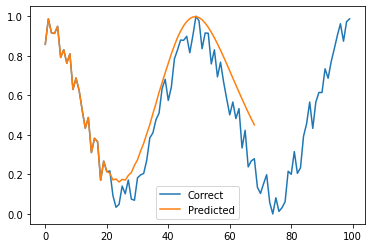

In [ ]:
# MSE誤差関数
loss_fnc = nn.MSELoss()
# 最適化アルゴリズム
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # 学習率は0.001
# 損失のログ
record_loss_train = []
# 学習
for i in range(1, EPOCHS+1):
    model.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す．x: 入力，t: 真値
        pred_y = model(x)
        loss = loss_fnc(pred_y, t.to(device))
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%20 == 0: # 20 epochごとに予測の様子を可視化
        print("Epoch:", i, "Loss_Train:", loss_train)
        predicted = list(input_data[0]) # 最初 (t=0～9) の入力をリスト化
        model.eval()
        with torch.no_grad():
          for i in range(n_sample):
            x = torch.tensor(predicted[-time_step:])  # 直近の時系列を取り出す
            x = x.reshape(1, time_step, 1)  # (バッチサイズ, 時系列の数, 入力の数)
            pred_y = model(x)
            predicted.append(pred_y[0].item())  # 予測結果をpredictedに追加する
        plt.plot(range(len(y)), y, label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()    

## 評価
- 損失関数の値の可視化
- 未学習部分の予測

を行ってみましょう．

### 損失関数の可視化

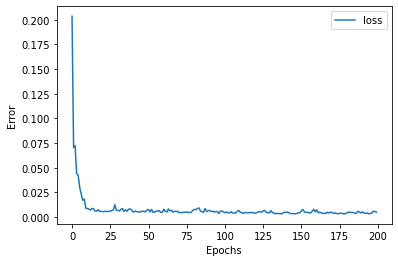

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(record_loss_train)), record_loss_train, label="loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

今回使用したパラメータの場合，25エポック程度で損失関数は横ばいとなることがわかります．

### 未学習部分の予測

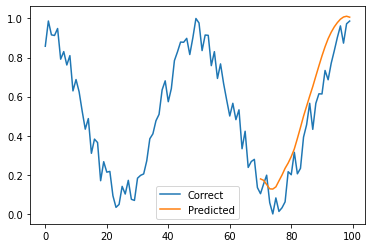

In [ ]:
# 空のデータを作る
n_test_sample = test_size  # サンプル数
test_input_data = np.zeros((n_test_sample, time_step, 1))
correct_test_data = np.zeros((n_test_sample, 1))

# テストデータの入力と真値を作る
start_test = train_size-time_step
for i in range(n_test_sample):
    test_input_data[i] = y[start_test+i:start_test+i+time_step]
    correct_test_data[i] = y[start_test+i+time_step]

test_input_data = torch.tensor(test_input_data, dtype=torch.float)  # テンソルに変換
correct_test_data = torch.tensor(correct_test_data, dtype=torch.float)

#以下は学習時の評価と同じ
predicted = list(test_input_data[0]) # 最初の入力をリスト化

model.eval()
with torch.no_grad():
  for i in range(n_test_sample):
      x = torch.tensor(predicted[-time_step:])  # 直近の時系列を取り出す
      x = x.reshape(1, time_step, 1)  # (バッチサイズ, 時系列の数, 入力の数)
      pred_y = model(x)
      predicted.append(pred_y[0].item())  # 予測結果をpredictedに追加する
plt.plot(range(len(y)), y, label="Correct")
plt.plot(range(start_test+time_step, start_test+len(predicted)), predicted[time_step:] , label='Predicted') # x要素の範囲に注意
plt.legend()
plt.show()


正規化前の元のスケールに戻して描画します．

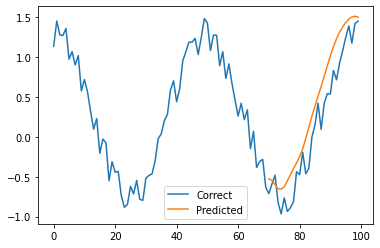

In [ ]:
y_pred = ms.inverse_transform(np.array(predicted[time_step:]).reshape(-1, 1))
y = ms.inverse_transform(y)

plt.plot(range(len(y)), y, label="Correct")
plt.plot(range(start_test+time_step, start_test+len(predicted)), y_pred , label='Predicted')
plt.legend()
plt.show()

最後に，予測した時系列データと真値のMSE, RMSEを計算します．

In [ ]:
from sklearn.metrics import mean_squared_error

y_true = y[-test_size:] # yの後方test_size個分のデータ
mse = mean_squared_error(y_true, y_pred)
print("mse", mse)
rmse = np.sqrt(mse)
print("rmse", rmse)

mse 0.09526523675308307
rmse 0.30865067107181715


このように，予測した波形と実際の波形の比較といった定性的な観点や，上記のような定量的な指標における評価をしながら，モデルやパラメータを改良していきます．

# RNNの課題と解決のアプローチ
上記の例は単純であったためそこそこ学習がうまくいきましたが、RNNには一般的に長期にわたる特徴の学習が困難という課題があります。その原因として以下の二つがあげられます。

## 勾配消失問題

勾配消失問題とは誤差逆伝播の過程で勾配が消失してしまう問題です。RNNの場合は時間のステップごとに隠れ層が増えていくので、長期の学習をする場合は大変深層になり、勾配消失問題がネックになります。

フィードフォワード型のNNでは活性化関数の形を試行錯誤したり事前学習をするなどして対応を試みましたが、RNNの場合は次に述べる重み衝突問題という特有の問題が発生するため、全く異なるアプローチで対応する必要があります。

## 重み衝突問題

重み衝突とは、「現在有用な情報には重みを大きく、有用でない場合は重みを小さくするが、現在有用でなくても将来的に有用になる場合は重みをどうすればよいのか？？」という、時系列データを扱うRNNならではの問題です。

すなわち、情報が長期的な特徴を持つのか短期的な特徴を持つのかわからない状態で、重みを大きくすべきか小さくすべきか判断することができない問題を重み衝突といいます。

RNNの場合は一時刻前の隠れ状態をそのまま入力するため、情報の有用性が将来的にどうなるかといったことは考えていません。そのため、短期的な記憶は学習できる一方、長期的な記憶を学習することができません。

なお、重み衝突は入力にかかる重みと一時刻前の隠れ層からの出力にかかる重みにそれぞれ発生し、入力重み衝突と出力重み衝突に分けられます。

<br>

上記2つの問題点の解決に取り組んだモデルとして**LSTM (Long Short-Term Memory)**, **GRU (Gated Reccurent Unit)**があり、現在よく使用されています。以下で各モデルについて説明します。

## LSTM

以下のセルを実行するとLSTMの説明スライドがノートブック上に表示されます。

あるいは、[こちらのリンク](https://docs.google.com/presentation/d/e/2PACX-1vReu-12nUWWo7_a_UiXdH3wk5lam8VuFOqjLxUc9GynOeM2P5I38RR2drL2D8deVw/pub?start=false&loop=false&delayms=3000)を押していただくと説明スライドのページへ遷移します。

In [ ]:
import IPython
from IPython.display import display, HTML

htm = HTML('''\
<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vReu-12nUWWo7_a_UiXdH3wk5lam8VuFOqjLxUc9GynOeM2P5I38RR2drL2D8deVw/embed?start=false&loop=false&delayms=3000" frameborder="0" width="640" height="389" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>
''')
display(htm)

## GRU

以下のセルを実行するとGRUの説明スライドがノートブック上に表示されます。

あるいは、[こちらのリンク](https://docs.google.com/presentation/d/e/2PACX-1vQMMVQuMuV_M7u-4hNKJ9nzUqs7dwRhv0-_rAtAiN4xEsq4s1eKXKFbdetzfe2EQQ/pub?start=false&loop=false&delayms=3000)を押していただくと説明スライドのページへ遷移します。

In [ ]:
import IPython
from IPython.display import display, HTML

htm = HTML('''\
<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vQMMVQuMuV_M7u-4hNKJ9nzUqs7dwRhv0-_rAtAiN4xEsq4s1eKXKFbdetzfe2EQQ/embed?start=false&loop=false&delayms=3000" frameborder="0" width="640" height="389" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>
''')
display(htm)

## LSTMとGRUの比較
一般に次のように言われています．
- 計算量：GRU < LSTM
- 性能：GRU <= LSTM


## LSTMとGRUの実装
PyTorchではLSTM, GRUのモデルはそれぞれ以下のように作成できます。

**LSTM**

実装は，nn.rnnがnn.LSTMに変わった以外は全く同じです．

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(LSTM, self).__init__()

        self.input_size = input_size # 入力データの次元
        self.hidden_dim = hidden_dim # 隠れ層の次元
        self.n_layers = n_layers # LSTMを「上方向に」何層重ねるか？の設定 ※横方向ではない

        # LSTMレイヤ．内部構造はすでに組まれている.
        # Dataloaderから取り出されるデータの仕様と合わせるためにbatch_first=True
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size) # 隠れ状態 ➡ 出力の全結合層

    def forward(self, x):
        x = x.to(device)
        y_lstm, h = self.lstm(x, None) # 隠れ層の初期値を0とする場合Noneでよい．
        y = self.fc(y_lstm[:, -1, :]) # 最後の時刻の出力だけを使用するので-1 (y_lstm[batch, time_step, hidden_size])
        return y


**GRU**

実装は，nn.rnnがnn.GRUに変わった以外は全く同じです．

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(GRU, self).__init__()

        self.input_size = input_size # 入力データの次元
        self.hidden_dim = hidden_dim # 隠れ層の次元
        self.n_layers = n_layers # GRUを「上方向に」何層重ねるか？の設定 ※横方向ではない

        # GRUレイヤ．内部構造はすでに組まれている.
        # Dataloaderから取り出されるデータの仕様と合わせるためにbatch_first=True
        self.gru = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size) # 隠れ状態 ➡ 出力の全結合層

    def forward(self, x):
        x = x.to(device)
        y_gru, h = self.gru(x, None) # 隠れ層の初期値を0とする場合Noneでよい．
        y = self.fc(y_gru[:, -1, :]) # 最後の時刻の出力だけを使用するので-1 (y_gru[batch, time_step, hidden_size])
        return y


In [ ]:
#RNNの設定
n_inputs  = 1 # 入力は一次元
n_outputs = 1 # 出力も一次元
n_hidden  = 64 # 隠れ状態を64個に設定
n_layers  = 1 # 普通のRNN

lstm = LSTM(n_inputs, n_outputs, n_hidden, n_layers).to(device) # LSTMをインスタンス化
print(lstm) # 作成したRNNの層を簡易表示
gru = GRU(n_inputs, n_outputs, n_hidden, n_layers).to(device) # GRUをインスタンス化
print(gru) # 作成したRNNの層を簡易表示

LSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
GRU(
  (gru): GRU(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


# 実践：株価予測

実在する時系列データでの実践課題として，株価予測を行います．

Webスクレイピングを用いて最新の株価情報を取得し，RNNを用いて予測を行います．

## データの準備

### スクレイピング

Webサイトから株価情報をスクレイピングします．

In [ ]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import urllib.request
import time

In [ ]:
def getstockfromweb():
  page_num = 15 # 取得するページ数．たくさん取得して可視化するとわかるが，コロナ前後で株価が大暴落しているので，遡る月日は15ページ程度（約1年）とした
  tstock = []
  for i in range(page_num):
    # Yahoo Financeのページを利用
    url = "https://finance.yahoo.co.jp/quote/998407.O/history?from=20170401&to=20220601&timeFrame=d&page=" + str(i+1) # 日付を変更したら最新のデータが取れる
    html = urllib.request.urlopen(url)
    soup = BeautifulSoup(html, "lxml")
    estock = [value.get_text() for value in soup.find_all("td")] # <td></td>に欲しい数値が文字で入っているのでその部分を抽出し、get_textで文字のみさらに抽出する
    estock = [s for s in estock if s != ''] # 空欄''でない要素を抽出
    tstock.extend(estock) # appendではなく一つの大きな配列にするためextendを使う
    time.sleep(0.1) # サーバに負担をかけないため間をあける
  tstock = np.array(tstock) # NumPyへ変換
  stock = tstock.reshape(-1, 5) # 表の形にreshape
  '''
  ・始値（はじめね）：最初に取引された価格
  ・高値（たかね）：最も高く取引された価格
  ・安値（やすね）：最も安く取引された価格
  ・終値（おわりね）：最後に取引された価格
  '''
  stock = pd.DataFrame(stock[:,1:5], columns=["Open Rate", "High Price", "Low Price", "Close Rate"], index=stock[:,0])
  return stock

In [ ]:
stock = getstockfromweb()
stock

,Open Rate,High Price,Low Price,Close Rate
2022年6月1日,"27,295.63","27,482.31","27,295.42","27,457.89"
2022年5月31日,"27,318.09","27,463.33","27,250.70","27,279.80"
2022年5月30日,"27,092.82","27,401.24","27,057.20","27,369.43"
2022年5月27日,"26,947.80","26,996.70","26,731.60","26,781.68"
2022年5月26日,"26,685.02","26,898.75","26,597.97","26,604.84"
...,...,...,...,...
2021年3月16日,"29,770.39","30,026.40","29,755.47","29,921.09"
2021年3月15日,"29,804.50","29,884.73","29,670.31","29,766.97"
2021年3月12日,"29,287.74","29,744.32","29,210.40","29,717.83"
2021年3月11日,"29,033.92","29,255.42","28,995.33","29,211.64"


In [ ]:
stock = stock.iloc[::-1] # デフォルトだと上から最新データになっているため，逆順にする
stock

,Open Rate,High Price,Low Price,Close Rate
2021年3月10日,"29,118.28","29,233.47","28,960.09","29,036.56"
2021年3月11日,"29,033.92","29,255.42","28,995.33","29,211.64"
2021年3月12日,"29,287.74","29,744.32","29,210.40","29,717.83"
2021年3月15日,"29,804.50","29,884.73","29,670.31","29,766.97"
2021年3月16日,"29,770.39","30,026.40","29,755.47","29,921.09"
...,...,...,...,...
2022年5月26日,"26,685.02","26,898.75","26,597.97","26,604.84"
2022年5月27日,"26,947.80","26,996.70","26,731.60","26,781.68"
2022年5月30日,"27,092.82","27,401.24","27,057.20","27,369.43"
2022年5月31日,"27,318.09","27,463.33","27,250.70","27,279.80"


In [ ]:
def str2float(x): # カンマが入った文字列の数字をfloat型に変換
  return float(x.replace(",", ""))

stock["Open Rate"] = stock["Open Rate"].apply(str2float)
stock["High Price"] = stock["High Price"].apply(str2float)
stock["Low Price"] = stock["Low Price"].apply(str2float)
stock["Close Rate"] = stock["Close Rate"].apply(str2float)

今回は終値の値を予測してみましょう．

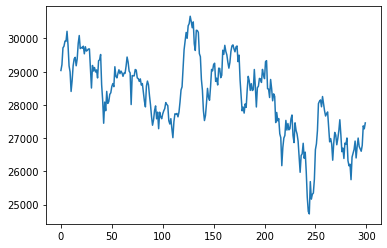

In [ ]:
y = stock["Close Rate"].values
plt.plot(y)

### データの前処理

ここからの手順は先ほどのcos波と同様です．

今回は値の範囲が明確にはわからないため，**標準化**を用いてスケーリングします．

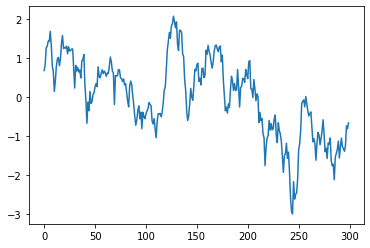

In [ ]:
from sklearn.preprocessing import StandardScaler # 正規化のモジュール
ss = StandardScaler() # 正規化のクラスを準備
# スケーリング
y = y.reshape(-1, 1) # fit_transformに入力できるようにreshape
y = ss.fit_transform(y) # 正規化
plt.plot(y)

## パラメータの定義
あとで調整しやすいように，主要なパラメータをまとめて宣言しておきます．

In [ ]:
train_test_split_rate = 0.8 # 何割をtrainにするか
time_step = 20 # 時系列データのステップ数．今回の場合は，何日分の価格遷移をみるか
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 400

## 訓練データの作成

In [ ]:
train_size = int(len(y)*train_test_split_rate)
test_size = len(y) - train_size

train = y[0:train_size, :]
test = y[train_size:len(y), :]

print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 240, test size: 60 


In [ ]:
n_sample = train_size-time_step-1  # サンプル数

input_data = np.zeros((n_sample, time_step, 1))  # 入力の空配列
correct_data = np.zeros((n_sample, 1))  # 正解の空配列

for i in range(n_sample):
    input_data[i] = y[i:i+time_step]
    correct_data[i] = y[i+time_step]  # 正解は入力よりも一つ後

PyTorchのDataLoaderで読み込みます．

In [ ]:
import torch
from torch.utils.data import DataLoader

input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)

dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)  # DataLoaderの設定

## モデルの構築

ここではGRUを使用してみます．

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(GRU, self).__init__()

        self.input_size = input_size # 入力データの次元
        self.hidden_dim = hidden_dim # 隠れ層の次元
        self.n_layers = n_layers # GRUを「上方向に」何層重ねるか？の設定 ※横方向ではない

        # GRUレイヤ．内部構造はすでに組まれている.
        # Dataloaderから取り出されるデータの仕様と合わせるためにbatch_first=True
        self.gru = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size) # 隠れ状態 ➡ 出力の全結合層

    def forward(self, x):
        x = x.to(device)
        y_gru, h = self.gru(x, None) # 隠れ層の初期値を0とする場合Noneでよい．
        y = self.fc(y_gru[:, -1, :]) # 最後の時刻の出力だけを使用するので-1 (y_gru[batch, time_step, hidden_size])
        return y


隠れ層の数も調整すべきパラメータでしょう．

In [ ]:
#RNNの設定
n_inputs  = 1 # 入力は一次元
n_outputs = 1 # 出力も一次元
n_hidden  = 128 # 隠れ状態を128個に設定
n_layers  = 1 # 普通のRNN

model = GRU(n_inputs, n_outputs, n_hidden, n_layers).to(device) # GRUをインスタンス化
print(model) # 作成したRNNの層を簡易表示

GRU(
  (gru): GRU(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


## 学習

50エポックごとに学習の様子を可視化してみます．

Epoch: 50 Loss_Train: 0.07717489664043699


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


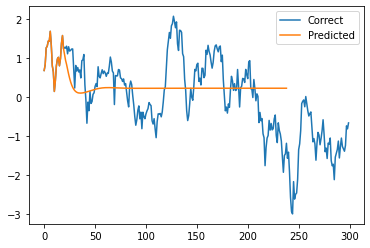

Epoch: 100 Loss_Train: 0.07029872121555465


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


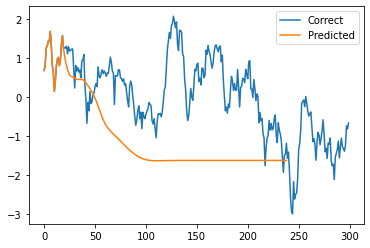

Epoch: 150 Loss_Train: 0.05442759341427258


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


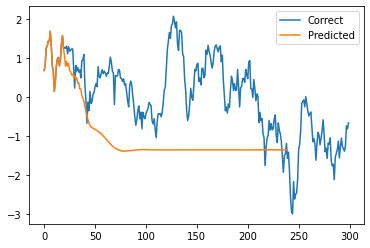

Epoch: 200 Loss_Train: 0.03407643549144268


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


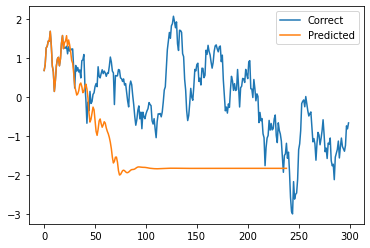

Epoch: 250 Loss_Train: 0.01899934254054512


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


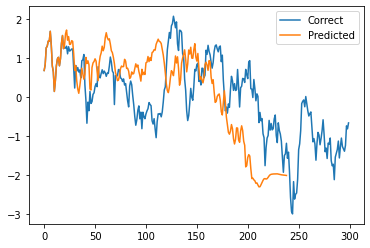

Epoch: 300 Loss_Train: 0.0052236531129372975


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


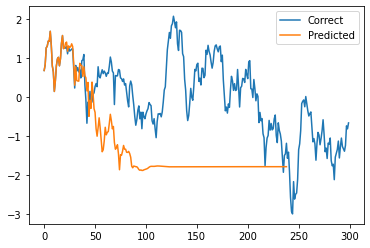

Epoch: 350 Loss_Train: 0.0016060930211097002


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


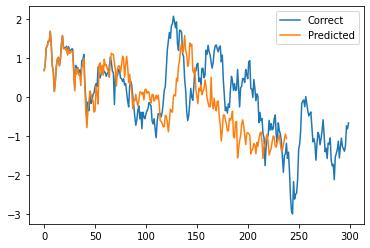

Epoch: 400 Loss_Train: 0.00024198292105990862


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


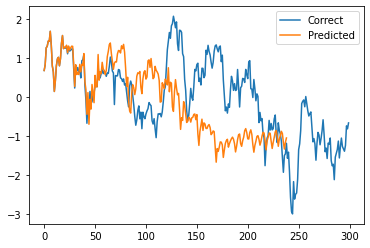

In [ ]:
# MSE誤差関数
loss_fnc = nn.MSELoss()
# 最適化アルゴリズム
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # 学習率は0.001
# 損失のログ
record_loss_train = []
# 学習
for i in range(1, EPOCHS+1):
    model.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す．x: 入力，t: 真値
        pred_y = model(x)
        loss = loss_fnc(pred_y, t.to(device))
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%50 == 0: # 50 epochごとに予測の様子を可視化
        print("Epoch:", i, "Loss_Train:", loss_train)
        predicted = list(input_data[0]) # 最初 (t=0～9) の入力をリスト化
        model.eval()
        with torch.no_grad():
          for i in range(n_sample):
            x = torch.tensor(predicted[-time_step:])  # 直近の時系列を取り出す
            x = x.reshape(1, time_step, 1)  # (バッチサイズ, 時系列の数, 入力の数)
            pred_y = model(x)
            predicted.append(pred_y[0].item())  # 予測結果をpredictedに追加する
        plt.plot(range(len(y)), y, label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()    

## 評価

### 損失関数の可視化

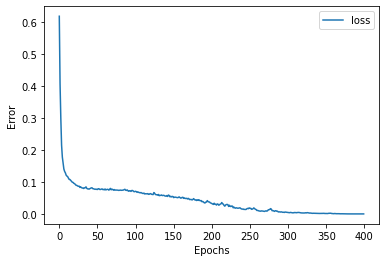

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(record_loss_train)), record_loss_train, label="loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

### 未学習部分の予測

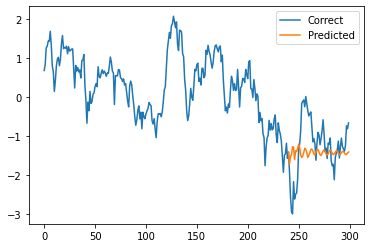

In [ ]:
# 空のデータを作る
n_test_sample = test_size  # サンプル数
test_input_data = np.zeros((n_test_sample, time_step, 1))
correct_test_data = np.zeros((n_test_sample, 1))

# テストデータの入力と真値を作る
start_test = train_size-time_step
for i in range(n_test_sample):
    test_input_data[i] = y[start_test+i:start_test+i+time_step]
    correct_test_data[i] = y[start_test+i+time_step]

test_input_data = torch.tensor(test_input_data, dtype=torch.float)  # テンソルに変換
correct_test_data = torch.tensor(correct_test_data, dtype=torch.float)

#以下は学習時の評価と同じ
predicted = list(test_input_data[0]) # 最初の入力をリスト化

model.eval()
with torch.no_grad():
  for i in range(n_test_sample):
      x = torch.tensor(predicted[-time_step:])  # 直近の時系列を取り出す
      x = x.reshape(1, time_step, 1)  # (バッチサイズ, 時系列の数, 入力の数)
      pred_y = model(x)
      predicted.append(pred_y[0].item())  # 予測結果をpredictedに追加する
plt.plot(range(len(y)), y, label="Correct")
plt.plot(range(start_test+time_step, start_test+len(predicted)), predicted[time_step:] , label='Predicted') # x要素の範囲に注意
plt.legend()
plt.show()


標準化前のスケールに戻して描画します．

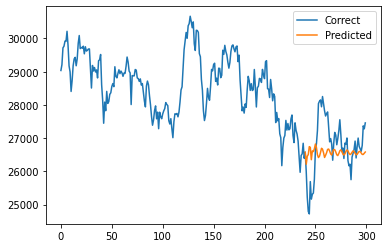

In [ ]:
y_pred = ss.inverse_transform(np.array(predicted[time_step:]).reshape(-1, 1))
y_original = ss.inverse_transform(y)

plt.plot(range(len(y_original)), y_original, label="Correct")
plt.plot(range(start_test+time_step, start_test+len(predicted)), y_pred , label='Predicted')
plt.legend()
plt.show()

最後に，予測した時系列データと真値のMSEとRMSEを計算します．

In [ ]:
from sklearn.metrics import mean_squared_error

y_true = y_original[-test_size:] # yの後方test_size個分のデータ
mse = mean_squared_error(y_true, y_pred)
print("mse", mse)
rmse = np.sqrt(mse)
print("rmse", rmse)

mse 718657.7660074314
rmse 847.7368495042736


## 未来の値を予測


ここで，未来の値の予測を行ってみます．この場合，学習データ数をより増やすために，現在持っているデータの全てを学習に用います．

今回のコードの場合，`train_test_split_rate = 1.0`とすれば，全データを学習に使用することができます．

In [ ]:
train_test_split_rate = 1.0 # 何割をtrainにするか

In [ ]:
train_size = int(len(y)*train_test_split_rate)
test_size = len(y) - train_size

train = y[0:train_size, :]
test = y[train_size:len(y), :]

print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 300, test size: 0 


In [ ]:
n_sample = train_size-time_step-1  # サンプル数

input_data = np.zeros((n_sample, time_step, 1))  # 入力の空配列
correct_data = np.zeros((n_sample, 1))  # 正解の空配列

for i in range(n_sample):
    input_data[i] = y[i:i+time_step]
    correct_data[i] = y[i+time_step]  # 正解は入力よりも一つ後

In [ ]:
import torch
from torch.utils.data import DataLoader

input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)

dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)  # DataLoaderの設定

再度，モデルの作成，学習のし直しを行います．

In [ ]:
model = GRU(n_inputs, n_outputs, n_hidden, n_layers).to(device) # GRUをインスタンス化
print(model) # 作成したRNNの層を簡易表示

GRU(
  (gru): GRU(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


Epoch: 50 Loss_Train: 0.08849869916836421


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


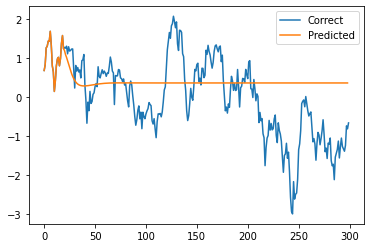

Epoch: 100 Loss_Train: 0.08019920976625548


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


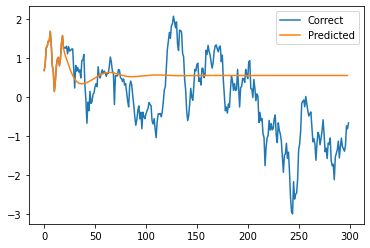

Epoch: 150 Loss_Train: 0.06623971172504955


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


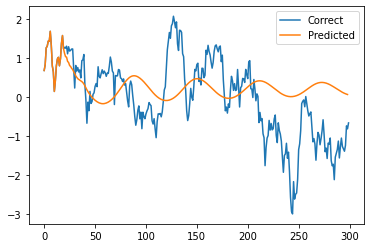

Epoch: 200 Loss_Train: 0.03718938140405549


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


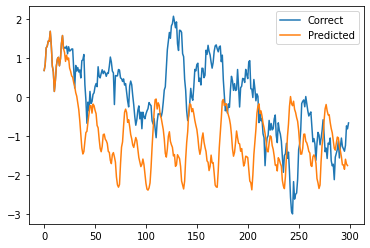

Epoch: 250 Loss_Train: 0.017359800533288054


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


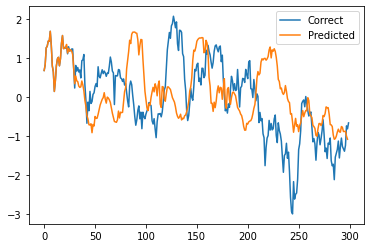

Epoch: 300 Loss_Train: 0.006554482039064169


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


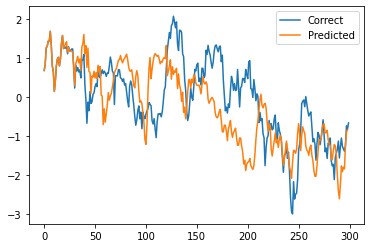

Epoch: 350 Loss_Train: 0.0019228062592446804


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


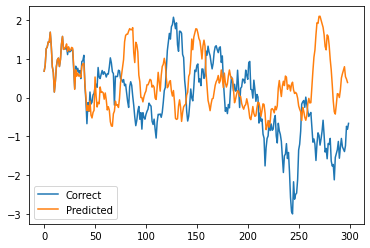

Epoch: 400 Loss_Train: 0.0014787366833641296


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


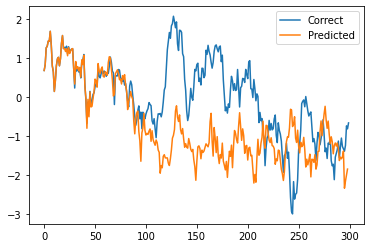

In [ ]:
# MSE誤差関数
loss_fnc = nn.MSELoss()
# 最適化アルゴリズム
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # 学習率は0.001
# 損失のログ
record_loss_train = []
# 学習
for i in range(1, EPOCHS+1):
    model.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す．x: 入力，t: 真値
        pred_y = model(x)
        loss = loss_fnc(pred_y, t.to(device))
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%50 == 0: # 50 epochごとに予測の様子を可視化
        print("Epoch:", i, "Loss_Train:", loss_train)
        predicted = list(input_data[0]) # 最初 (t=0～19) の入力をリスト化
        model.eval()
        with torch.no_grad():
          for i in range(n_sample):
            x = torch.tensor(predicted[-time_step:])  # 直近の時系列を取り出す
            x = x.reshape(1, time_step, 1)  # (バッチサイズ, 時系列の数, 入力の数)
            pred_y = model(x)
            predicted.append(pred_y[0].item())  # 予測結果をpredictedに追加する
        plt.plot(range(len(y)), y, label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()    

その後，以下のコードを実行することで未来の値を予測することができます．

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


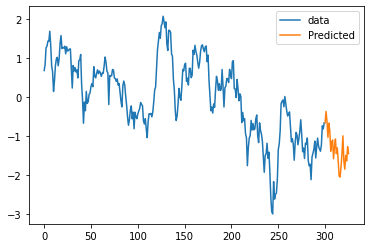

In [ ]:
# 未来予測するステップ数
future_step = 25

# 真値との比較による評価は行わないため，テストデータは作らない

# 末尾time_step分の要素を最初の入力とする
input_data = torch.tensor(y[-time_step:], dtype=torch.float)  # テンソルに変換
predicted = list(input_data) # 末尾time_step分の要素を最初の入力とする

model.eval()
with torch.no_grad():
  for i in range(future_step):
      x = torch.tensor(predicted[-time_step:])  # 直近の時系列を取り出す
      x = x.reshape(1, time_step, 1)  # (バッチサイズ, 時系列の数, 入力の数)
      pred_y = model(x)
      predicted.append(pred_y[0].item())  # 予測結果をpredictedに追加する

# 標準化された状態での結果
plt.plot(range(len(y)), y, label="data")
plt.plot(range(len(y), len(y)+future_step+1), predicted[time_step-1:] , label='Predicted') # dataの最後の点と最初の予測値を線分で結ぶため，predicted[time_step-1:]からplotを開始
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  


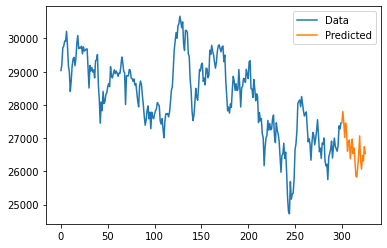

In [ ]:
# 標準化をもとに戻す
y_pred = ss.inverse_transform(np.array(predicted[time_step-1:]).reshape(-1, 1))
y_original = ss.inverse_transform(y)

plt.plot(range(len(y_original)), y_original, label="Data")
plt.plot(range(len(y_original), len(y_original)+future_step+1), y_pred, label='Predicted')
plt.legend()
plt.show()

## 考えられる工夫

**データを学習しやすいように前処理**
- 時系列データ以外にも着目
  - 曜日や月の何週目かなど
  - 日付がわかっているので上記の特徴量を新たに生成可能 ➡ <font color= "red">特徴量エンジニアリング</font>
    - 「機械学習入門」講習会で扱われています
  - 参考：https://kino-code.com/python-stock-price/
- 移動平均
  - 株価変動の大まかな傾向を知りたい場合，移動平均でデータを均してから学習させることがあります
    - 参考：https://qiita.com/seiji1997/items/bee6b75b4b461ee3a7b2
  - ちなみに，移動平均自体が株価変動傾向を推測するための簡単な指標として使われています
    - 参考：https://info.monex.co.jp/technical-analysis/indicators/001.html

**学習モデルの設計**
- 論文の学習モデルをマネする
  - 株価予測は調べると結構出てきます
  - 例）[A. Moghar, M. Hamiche, "Stock Market Prediction Using LSTM Recurrent Neural Network,"
Procedia Computer Science, Vol. 170, pp. 1168-1173, 2020.](https://www.sciencedirect.com/science/article/pii/S1877050920304865)

    <img src='https://raw.githubusercontent.com/Toshiki-Keio/introduction-to-deep-learning/main/day5/fig/4.png' width="400" >

  - 50日分の時系列データを学習させ，モデルは4層のLSTMの間にDropoutを挟んだもので，隠れ状態は96個のようです．（何％Dropoutするのかは書いてないですね，，）
    - PyTorchで実装するなら以下のようになると思います．

    ```python
    class LSTM(nn.Module):
        def __init__(self, input_size, output_size, hidden_dim, n_layers, dropout):
            super(LSTM, self).__init__()

            self.input_size = input_size # 入力データの次元
            self.hidden_dim = hidden_dim # 隠れ層の次元
            self.n_layers = n_layers # LSTMを「上方向に」何層重ねるか？の設定 ※横方向ではない

            # LSTMレイヤ．内部構造はすでに組まれている.
            # Dataloaderから取り出されるデータの仕様と合わせるためにbatch_first=True
            self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=dropout, batch_first=True)
            self.fc = nn.Linear(hidden_dim, output_size) # 隠れ状態 ➡ 出力の全結合層

        def forward(self, x):
            x = x.to(device)
            y_lstm, h = self.lstm(x, None) # 隠れ層の初期値を0とする場合Noneでよい．
            y = self.fc(y_lstm[:, -1, :]) # 最後の時刻の出力だけを使用するので-1 (y_lstm[batch, time_step, hidden_size])
            return y
    #RNNの設定
    n_inputs  = 1 # 入力は一次元
    n_outputs = 1 # 出力も一次元
    n_hidden  = 96 # 隠れ状態を96個に設定
    n_layers  = 4 # 4層LSTM
    dropout = 0.5 # dropout率を0.5とする

    model = LSTM(n_inputs, n_outputs, n_hidden, n_layers, dropout).to(device) # LSTMをインスタンス化
    print(model) # 作成したRNNの層を簡易表示
    ```
    割とうまく動いたので，皆さんもぜひ上記モデル試してみてください．

- その他，第三回で扱ったテクニック等

# 演習課題：新型コロナウイルス感染者数予測

これまで学んだことを生かして，新型コロナウイルス感染者数の予測を行ってみましょう！

<br>

---
## 課題
本講習会受講日の二週間後（14日後）の東京都における新型コロナウイルス感染者数を予測せよ．

---

<br>

本講習会を順調に受講している方は，6/23の二週間後の**7/7の感染者数を予測**し，**予測した感染者数**をK-LMSの課題モジュールにぜひ提出してください！もし可能であればその際に**作成したコード**も添付していただけると助かります！（**〆切：7/6 23:59**）

最も正確に当てられた解答を後日紹介させていただきたいです！

## データの準備

### データのダウンロード

In [ ]:
import pandas as pd

In [ ]:
covid_data = pd.read_csv("https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv")

In [ ]:
covid_data

,Date,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
0,2020/1/16,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020/1/17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020/1/18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020/1/19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020/1/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,2022/6/2,20675,1215,222,191,248,69,80,114,260,...,187,91,1219,125,326,386,255,288,442,1373
869,2022/6/3,19263,1038,210,170,296,68,85,133,315,...,208,91,1081,113,362,363,161,292,424,1326
870,2022/6/4,18238,899,185,170,274,81,70,112,251,...,166,103,908,119,295,353,183,236,406,1341
871,2022/6/5,15099,910,137,145,205,58,40,137,243,...,128,78,812,48,213,209,111,170,318,1247


今回は東京都の感染者数を予測してみましょう.

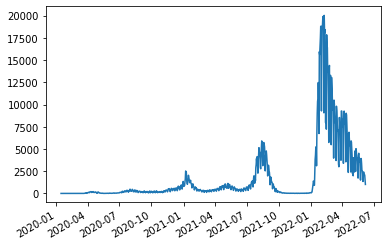

In [ ]:
X = pd.to_datetime(covid_data["Date"])# datetime型に変換
Y = covid_data["Tokyo"].values
import matplotlib.dates as mdates
plt.plot(X,Y)
plt.gcf().autofmt_xdate() # 日付のフォーマットを整えてくれる
plt.show()

### データの前処理

データのうち，どの区間のデータを学習に用いるかは自由です．これによって予測精度が大きく変わる可能性もありますね．

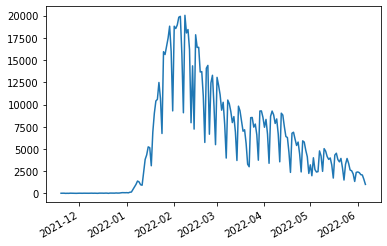

In [ ]:
# 例）直近200日を用いる場合
x = X[-200:]
y = Y[-200:]
plt.plot(x,y)
plt.gcf().autofmt_xdate() # 日付のフォーマットを整えてくれる
plt.show()

ここから先は，これまで学んだことを生かして自分で実装してみてください！

# 参考文献

- 杜 世橋，現場で使える！PyTorch開発入門 深層学習モデルの作成とアプリケーションへの実装
  - 慶應生は[KOSMOS](https://search.lib.keio.ac.jp/permalink/81SOKEI_KEIO/188bto4/alma9926574653504034)でオンラインで無料で閲覧できます
-  [[PyTorch] RNNを使った時系列予測](https://qiita.com/ku_a_i/items/0ea4b93d767ce7c83145)

- [正規化・標準化を徹底解説 （Python 前処理 サンプルコード付き）](https://www.codexa.net/normalization-python/)

- [Feature Scalingはなぜ必要？](https://qiita.com/ttskng/items/2a33c1ca925e4501e609)

- [〈機械学習基礎〉数式なし！ LSTM・GRU超入門](https://agirobots.com/lstmgruentrance-noformula/)

- データシステムの知能化とデザイン　講義資料（SD 西宏章教授）
